# Using vireo for multiplexing, followed by lineage tracing of those groups

# 1. Set up

In [1]:
import os
os.chdir("/data2/mito_lineage/")#Analysis/multiplex")

In [2]:
# papermill --cwd /data2/mito_lineage -p INDIR {INDIR} -p OUTDIR data/processed/mttrace/CHIP_april08_2021_Croker/MTblacklist/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/clones -p  src/vireo/2_MT_Lineage_Construct.ipynb 

In [3]:
pwd

'/data2/mito_lineage'

### Remove this when running in snakemake

## 1.1 Parameters

In [4]:
DEBUG=True
INDIR= "data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donors_mgatk_in/donor0/donor_mgatk/vireoIn/"
OUTDIR = "data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donors_mgatk_in/donor0/donor_mgatk/vireoIn/clones"
N_DONORS=2
#donor = 0
#n_clone_list="20,40,100"#[20, 40, 100]
nclones=20

In [5]:
nclones = int(nclones)
# n_clone_list = [int(x) for x in n_clone_list.split(",")]
# n_clone_list

[20, 40, 100]

## 1.2 Import packages

In [6]:
from os.path import join, exists, dirname
from icecream import ic
from glob import glob
import mplh.cluster_help as ch
import os
from vireoSNP.plot.base_plot import heat_matrix
from vireoSNP import Vireo
import src.pseudo_batch as pb
import vireoSNP
ic(vireoSNP.__version__)
from tqdm import tqdm
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from src.vireo.vireo_utils import run_vireo, plot_vireo_out, extract_clusters, run_elbo, separate_donors
%load_ext autoreload
%autoreload 2
from src.vireo.vireo_utils import run_lineage
#np.set_icoptions(formatter={'float': lambda x: format(x, '.5f')})

ic| vireoSNP.__version__: '0.5.6'


In [7]:
if not DEBUG:
    ic.disable()


# 2 Lineage construction for each donor

In [8]:
cells_meta = pd.read_csv(join(INDIR, f"cells_meta.tsv"), sep='\t')

cells_meta=cells_meta.astype({"donor_index": "Int64", "donor": "Int64"})
cells_meta

,index,ID,raw ID,new index,condition,donor,donor_index
0,0,AAACGAAAGCCGCAAA-1_pre,AAACGAAAGCCGCAAA-1,1,pre,0,1
1,1,AAACGAAAGGCTCCTG-1_pre,AAACGAAAGGCTCCTG-1,2,pre,1,1
2,2,AAACGAAAGTAGCAAT-1_pre,AAACGAAAGTAGCAAT-1,3,pre,0,2
3,3,AAACGAAAGTGAATAC-1_pre,AAACGAAAGTGAATAC-1,4,pre,1,2
4,4,AAACGAAAGTGTCACT-1_pre,AAACGAAAGTGTCACT-1,5,pre,1,3
...,...,...,...,...,...,...,...
15584,15584,TTTGTGTTCCGGAAAG-1_post,TTTGTGTTCCGGAAAG-1,15585,post,0,8015
15585,15585,TTTGTGTTCCTGACCT-1_post,TTTGTGTTCCTGACCT-1,15586,post,0,8016
15586,15586,TTTGTGTTCGGATGTT-1_post,TTTGTGTTCGGATGTT-1,15587,post,1,6745
15587,15587,TTTGTGTTCTTAATCC-1_post,TTTGTGTTCTTAATCC-1,15588,post,0,8017


In [9]:
# cells_meta = cells_meta[cells_meta["donor"]== donor]
# cells_meta.shape

(8017, 7)

ic| curr_ad_f: 'data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donors_mgatk_in/donor0/donor_mgatk/vireoIn/cellSNP.tag.AD.mtx'
ic| curr_dp_f: 'data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/donors_mgatk_in/donor0/donor_mgatk/vireoIn/cellSNP.tag.DP.mtx'
ic| curr_vcf.head():   #CHROM  POS  REF ALT  strand_correlation       vmr  n_cells_over_5  \
                     0   chrM   49  49A   G            0.919977  0.057158              38   
                     1   chrM   57  57T   C            0.710712  0.092318             966   
                     2   chrM   58  58T   C            0.849188  0.086032             781   
                     3   chrM   64  64C   T            0.918775  0.390651            5295   
                     4   chrM   66  66G   T            0.967001  0.50

[-763688.2494781557, -757041.3614544361, -753270.9609051482, -765175.0826547528, -772724.90309703, -758583.2427963386, -763946.2159921818, -768554.2023396585, -762653.9287755787, -761397.2531068076, -756589.2298391892, -767263.5047311857, -767789.4411448757, -764419.0952093205, -759246.4408593103, -765751.2611468874, -761557.6165130311, -758947.2750887866, -763649.8604579498, -760351.391076064, -766946.8759892567, -758538.3882051774, -763153.8865330438, -756402.4392262634, -759740.0179321873, -760604.6512663234, -764456.9398179152, -761914.9151412388, -761850.0085903795, -748784.2228530983, -757644.6722124827, -763838.0471905207, -764812.1498677738, -763350.8388732981, -767824.0031379655, -767859.9242139028, -763835.8070490304, -760931.1771114476, -754119.220904238, -764109.5900858843, -759687.6441315508, -761564.1538103633, -756762.8969191066, -764792.9335048106, -754178.4277822727, -759409.2036969508, -763345.8811188994, -752911.1612278596, -765002.1846045151, -757427.6057701581]


ic| 'Before filtering'
ic| cells_meta.shape: (8017, 7)
ic| 'After filtering'
ic| cells_meta.shape: (8017, 8)
ic| allAD.shape: (358, 5297)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (8017, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (8017, 10)
ic| len(curr_dp

lineage 0: 10 cells 
(303, 3)
(303, 3)
donor0_lineage0
lineage 1: 29 cells 
(885, 3)
(885, 3)
donor0_lineage1


["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (8017, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (8017, 10)
ic| len(curr_dp["Cell

lineage 2: 1 cells 
(38, 3)
(38, 3)
donor0_lineage2
lineage 3: 39 cells 
(1177, 3)
(1177, 3)
donor0_lineage3


"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (8017, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (8017, 10)
ic| len(curr_dp["Cell"].unique())

lineage 4: 0 cells 
(0, 3)
(0, 3)
donor0_lineage4
lineage 5: 2 cells 
(57, 3)
(57, 3)
donor0_lineage5


-len(keep_inds): 0
ic| cells_meta.shape: (8017, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (8017, 10)


lineage 6: 95 cells 
(2985, 3)
(2985, 3)
donor0_lineage6
lineage 7: 0 cells 
(0, 3)
(0, 3)
donor0_lineage7


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (8017, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (8017, 10)


lineage 8: 562 cells 
(17148, 3)
(17148, 3)
donor0_lineage8


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (8017, 10)


lineage 9: 10 cells 
(294, 3)
(294, 3)
donor0_lineage9
lineage 10: 1328 cells 
(40538, 3)
(40538, 3)
donor0_lineage10


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (8017, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (8017, 10)


lineage 11: 0 cells 
(0, 3)
(0, 3)
donor0_lineage11
lineage 12: 102 cells 
(3113, 3)
(3113, 3)
donor0_lineage12


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (8017, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (8017, 10)


lineage 13: 660 cells 
(20176, 3)
(20176, 3)
donor0_lineage13


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (8017, 10)
ic| len(curr_dp["Cell"].unique())-len(

lineage 14: 43 cells 
(1354, 3)
(1354, 3)
donor0_lineage14
lineage 15: 2 cells 
(75, 3)
(75, 3)
donor0_lineage15


keep_inds): 0
ic| cells_meta.shape: (8017, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (8017, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0

lineage 16: 0 cells 
(0, 3)
(0, 3)
donor0_lineage16
lineage 17: 2 cells 
(83, 3)
(83, 3)
donor0_lineage17



ic| cells_meta.shape: (8017, 10)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (8017, 10)


lineage 18: 27 cells 
(846, 3)
(846, 3)
donor0_lineage18
lineage 19: 635 cells 
(19374, 3)
(19374, 3)
donor0_lineage19


ic| lin_cells_meta.head():    level_0  index                      ID              raw ID  new index  \
                           0        0      0  AAACGAAAGCCGCAAA-1_pre  AAACGAAAGCCGCAAA-1          1   
                           1        2      2  AAACGAAAGTAGCAAT-1_pre  AAACGAAAGTAGCAAT-1          3   
                           2        5      5  AAACGAACACGGCCAT-1_pre  AAACGAACACGGCCAT-1          6   
                           3        7      7  AAACGAACATTAACGC-1_pre  AAACGAACATTAACGC-1          8   
                           4        9      9  AAACGAAGTTTAAGGA-1_pre  AAACGAAGTTTAAGGA-1         10   
                           
                             condition  donor  donor_index  lineage  lineage_index  
                           0       pre      0            1     10.0            1.0  
                           1       pre      0            2      NaN            NaN  
                           2       pre      0            3     19.0            1.0  
              

ValueError: Shape of passed values is (5297, 20), indices imply (8017, 20)

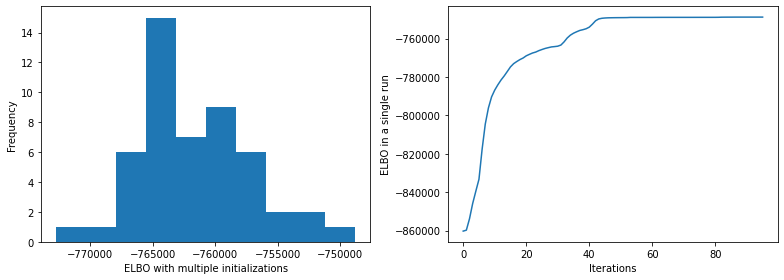

In [10]:
curr_ad_f = join(INDIR, f"cellSNP.tag.AD.mtx")
curr_dp_f = join(INDIR, f"cellSNP.tag.DP.mtx")
curr_vcf_f = join(INDIR, f"cellSNP.base.vcf")

for donor in np.arange(N_DONORS):
    prefix=f"donor{donor}_"
    #for clone in n_clone_list:
    cells_meta_col = f"lineage{nclones}"
    curr_outdir = join(OUTDIR, cells_meta_col)
    if not exists(curr_outdir):
        os.mkdir(curr_outdir)
    curr_cells_meta = cells_meta.copy()

    ic(curr_ad_f)
    ic(curr_dp_f)
    curr_ad = mmread(curr_ad_f).tocsc()
    curr_dp = mmread(curr_dp_f).tocsc() 
    curr_vcf = pd.read_csv(curr_vcf_f, sep='\t')
    ic(curr_vcf.head())

    model_name = f"lineage_{nclones}"
    modelCA, elbo = run_vireo(curr_ad, curr_dp, nclones, n_cores=32, plot_qc=True,out_f=join(curr_outdir, model_name))
    try:
        doublet_prob = modelCA.predict_doublet(curr_ad, curr_dp, update_GT=False, update_ID=False)[0].sum(axis=1)
    except AttributeError: # New version of Vireo 2021
        #doublet_prob = vireoSNP.utils.vireo_doublet.predict_doublet(modelCA,AD, DP, update_GT=False, update_ID=False)[0].sum(axis=1)
        doublet_prob = vireoSNP.utils.vireo_doublet.predict_doublet(modelCA, curr_ad, curr_dp, update_GT=False, update_ID=False)[0].sum(axis=1)


    separate_donors(curr_ad, curr_dp, modelCA, curr_cells_meta, curr_outdir,
                    doublet_prob,
                    prob_thresh=0.9, doublet_thresh=0.9,
                    cells_ind_col='donor_index',
                    out_name="lineage", prefix=prefix, cells_filt_col="donor", 
                    cells_filt_val=donor, vars_meta=curr_vcf)   
    lin_cells_meta = pd.read_csv(join(curr_outdir, f"{prefix}cells_meta.tsv"), sep='\t')
    ic(lin_cells_meta.head())
    ic(lin_cells_meta.shape)
    ic("Plotting AF SNPs")
    lin_cells_meta = lin_cells_meta.astype({"lineage": 'Int64'}).fillna(-1).astype(str)
    plot_vireo_out(modelCA, out_f=join(curr_outdir, model_name), 
                   labels=lin_cells_meta[["condition", "lineage"]], 
                   doublet_prob=doublet_prob)

    plt.close()


In [ ]:
lin_cells_meta = pd.read_csv(join(OUTDIR, f"{prefix}cells_meta.tsv"), sep='\t')
ic(lin_cells_meta.head())
ic(lin_cells_meta.shape)
ic("Plotting AF SNPs")
lin_cells_meta = lin_cells_meta.astype({"lineage": 'Int64'}).fillna(-1).astype(str)
plot_vireo_out(modelCA, out_f=join(OUTDIR, model_name+"OUT"), 
               labels=lin_cells_meta[["condition", "lineage"]], 
               doublet_prob=doublet_prob)

In [ ]:
lin_cells_meta

In [ ]:
(lin_cells_meta["lineage"]!="-1").sum()

In [ ]:
lin_cells_meta